## **5.4. AdaBoost Classifier**

Overall: The performance of the AdaBoost model surpasses that of the unsupervised approaches; however, it remains inferior to the XGBoost and Random Forest models. Specifically, AdaBoost successfully identified approximately 90% of fraudulent transactions but exhibited a relatively low precision (0.0877), meaning that a high incidence of false alarms and according to the confusion matrix, mostly fell into false positives. Nevertheless, with an overall accuracy of 0.9836, the AdaBoost model can still be regarded as a reasonably effective classification method within this context.

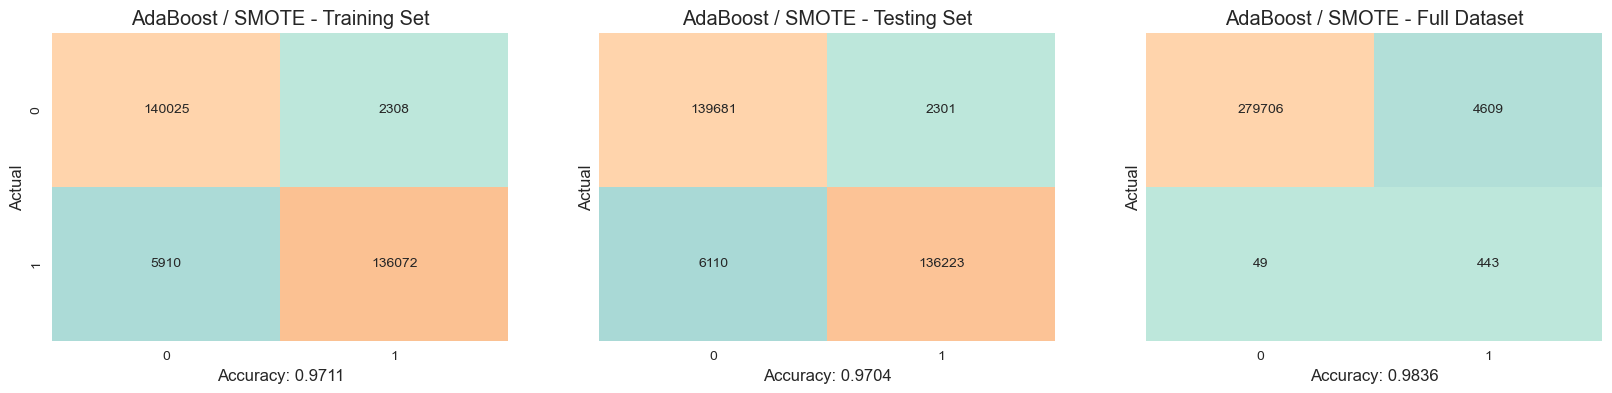

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost model
ada_model = AdaBoostClassifier(
    random_state=0,
    algorithm='SAMME',
    learning_rate=0.5,
    n_estimators=100
)

# Fit model and make predictions
model, y_pred = Models(ada_model, X_train, X_test, y_train, y_test, df, title="AdaBoost / SMOTE")

In [ ]:
# Feature importances
imp_df = FeatureImportances(ada_model, X_train, y_train, df)
print(imp_df)

   Feature  Importance  Cumulative Importance
0       V4    0.256805               0.409354
1      V14    0.179490               0.857148
2       V1    0.089257               0.102619
3      V10    0.084256               0.596361
4      V12    0.068312               0.677658
5       V3    0.049930               0.152550
6      V17    0.047868               0.950494
7      V16    0.045478               0.902626
8       V9    0.044831               0.512105
9       V8    0.028097               0.467274
10      V6    0.017116               0.426470
11     V21    0.015014               0.989553
12     V19    0.014434               0.974539
13    Time    0.013362               0.013362
14     V11    0.012985               0.609346
15      V7    0.012707               0.439176
16     V22    0.010447               1.000000
17     V18    0.009611               0.960105
18     V26    0.000000               1.000000
19     V24    0.000000               1.000000
20     V27    0.000000            

The top eight features account for 82.14% of the total feature importance in the AdaBoost model, indicating that these variables play a dominant role in shaping its predictive capability. Among them, V4 is identified as the most influential feature, contributing 23.68%, followed by V14 with 17.95%. These eight features show a strong correlation with the target variable (Class) and are also recognized as key predictors in the Random Forest model, suggesting consistency across different ensemble learning approaches.

In contrast, 12 features, including “Amount”, V2, V5, V13, V15, V20, and V23–V28, exhibit no measurable contribution to the model’s performance, implying that they provide minimal or redundant information for fraud detection within this dataset.


In [ ]:
# Full dataset
X_all, y_all = Definedata(df)

# Classification report
report = classification_report(y_all, y_pred, digits=4)
print("Classification Report (Full Dataset)")
print(report)

# Get probabilities for the positive class (Class=1)
y_proba_ada = ada_model.predict_proba(X_all)[:,1]

# ROC-AUC
roc_auc_ada = roc_auc_score(y_all, y_proba_ada)
print(f"ROC AUC Score (Full Dataset): {roc_auc_ada:.5f}")

# Confusion Matrix
cm = confusion_matrix(y_all, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(cm.shape[0])],
                     columns=[f"Pred_{i}" for i in range(cm.shape[1])])
print("Confusion Matrix (Full Dataset):")
print(cm_df)

Classification Report (Full Dataset)
              precision    recall  f1-score   support

           0     0.9998    0.9838    0.9917    284315
           1     0.0877    0.9004    0.1598       492

    accuracy                         0.9836    284807
   macro avg     0.5438    0.9421    0.5758    284807
weighted avg     0.9982    0.9836    0.9903    284807

ROC AUC Score (Full Dataset): 0.98654
Confusion Matrix (Full Dataset):
          Pred_0  Pred_1
Actual_0  279706    4609
Actual_1      49     443


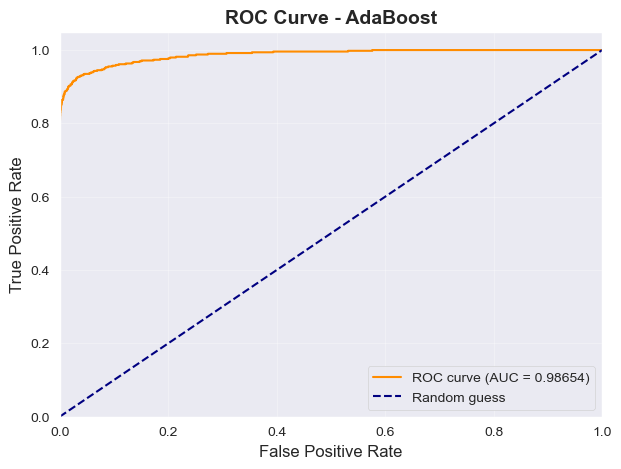

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, y_proba_ada)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc_ada:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - AdaBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Calculate Gini coefficient
gini_ada = 2 * roc_auc_ada - 1
print(f"Gini Coefficient of AdaBoost: {gini_ada:.4f}")

Gini Coefficient of AdaBoost: 0.9731


The ROC curve illustrates that the AdaBoost model performs effectively in detecting fraudulent transactions, demonstrating a classification ability that is substantially superior to random guessing. The model achieves a GINI of 0.9731, a value approaching 1, indicating a relatively strong level of discriminatory power between fraudulent and legitimate cases.

## **5.6. Light GBM**

Overall: Though it can detect all fraudulent transactions and has no false negatives, Light GBM has the lowest level of accuracy between the assessed machine learning algorithms (0.7627). The model has extremely low precision (0.0072) and F1-score (0.0144), and the scores are explained further by the confusion matrix, where 67,578 normal transactions are misclassified as fraud.  Although this yields a very high ROC AUC score of 0.9946, indicating excellent overall ranking ability, the model’s real-world applicability is limited because it would generate an excessive number of false alarms in operational settings.

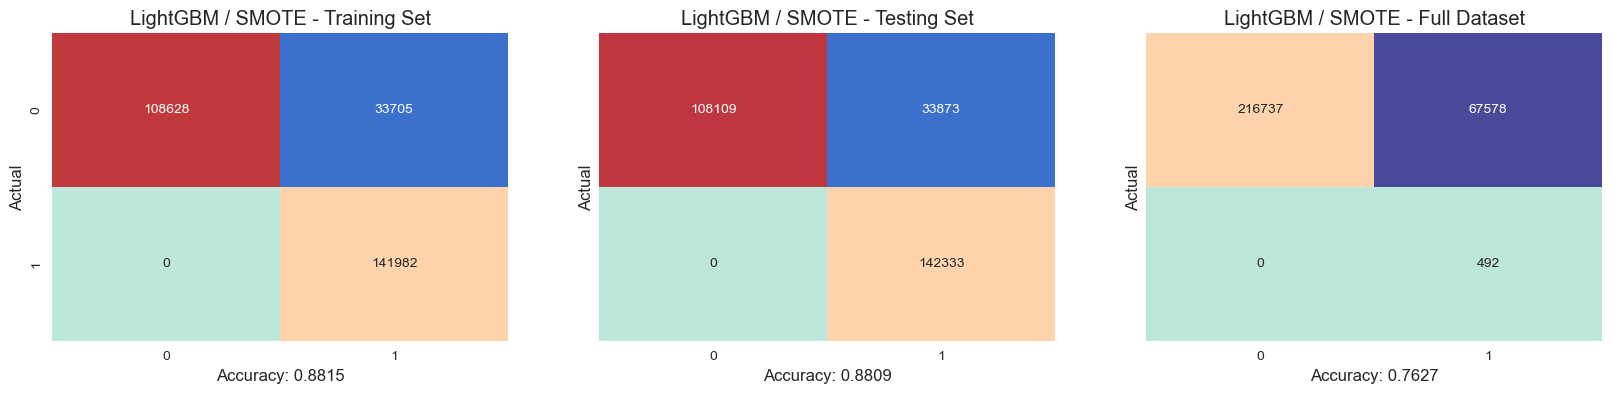

In [ ]:
# LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 7,              # should be smaller than 2^(max_depth)
    'max_depth': 4,               # -1 means no limit
    'min_child_samples': 100,     # minimum data in one leaf
    'max_bin': 100,               # number of bins for feature values
    'subsample': 0.9,             # subsample ratio for training data
    'subsample_freq': 1,          # frequency of subsampling
    'colsample_bytree': 0.7,      # ratio of columns for each tree
    'min_child_weight': 0,        # minimum sum of instance weight in a leaf
    'min_split_gain': 0,          # minimum loss reduction required to make a split
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 150       # for highly imbalanced data
}

# Train LightGBM model
lgbm_model = LGBMClassifier(random_state=0, **params)

# Fit model and make predictions (using your custom Models() function)
model, y_pred = Models(lgbm_model, X_train, X_test, y_train, y_test, df, title="LightGBM / SMOTE")


In [ ]:
# Feature importances
imp_df = FeatureImportances(lgbm_model, X_train, y_train, df)
print(imp_df)

   Feature  Importance  Cumulative Importance
0       V4          95                    245
1      V14          82                    494
2       V1          52                     91
3       V8          48                    308
4      V12          47                    404
5       V3          43                    150
6     Time          39                     39
7      V10          30                    341
8      V11          16                    357
9       V2          16                    107
10     V18          15                    527
11     V19          11                    538
12     V25          10                    583
13     V16          10                    506
14      V5           9                    254
15     V13           8                    412
16     V20           8                    546
17     V22           8                    561
18     V24           7                    573
19     V26           7                    590
20     V21           7            

In [ ]:
# Full dataset
X_all, y_all = Definedata(df)

# classification report
report = classification_report(y_all, y_pred, digits=4)
print("Classification Report (Full Dataset)")
print(report)

# Get probabilities for the positive class (Class=1)
y_proba_lgbm = lgbm_model.predict_proba(X_all)[:,1]

# ROC-AUC
roc_auc_lgbm = roc_auc_score(y_all, y_proba_lgbm)
print(f"ROC AUC Score (Full Dataset): {roc_auc:.5f}")

# Confusion Matrix
cm = confusion_matrix(y_all, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(cm.shape[0])],
                     columns=[f"Pred_{i}" for i in range(cm.shape[1])])
print("Confusion Matrix (Full Dataset):")
print(cm_df)

Classification Report (Full Dataset)
              precision    recall  f1-score   support

           0     1.0000    0.7623    0.8651    284315
           1     0.0072    1.0000    0.0144       492

    accuracy                         0.7627    284807
   macro avg     0.5036    0.8812    0.4397    284807
weighted avg     0.9983    0.7627    0.8637    284807

ROC AUC Score (Full Dataset): 0.95497
Confusion Matrix (Full Dataset):
          Pred_0  Pred_1
Actual_0  216737   67578
Actual_1       0     492


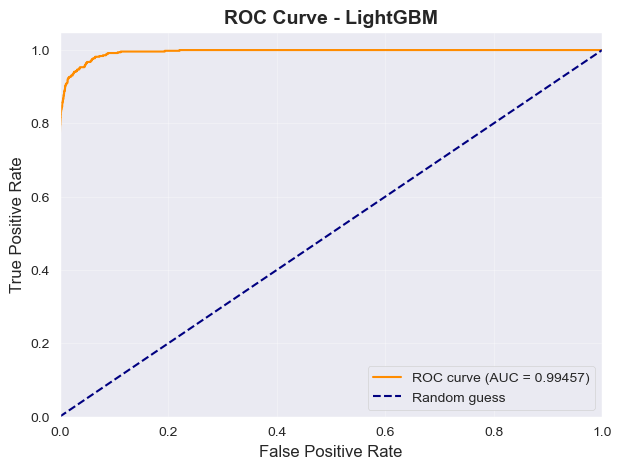

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, y_proba_lgbm)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc_lgbm:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - LightGBM', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Calculate Gini coefficient
gini_lgbm = 2 * roc_auc_lgbm - 1
print(f"Gini Coefficient of CatBoost: {gini_lgbm:.4f}")

Gini Coefficient of CatBoost: 0.9891


The feature importance table for Light GBM shows the split importance, or the number of times the model used each feature to split data. In total, the model split 600 times, the top 11 accounts for 487 times or 80% number the needed time splits. Besides familiar highly correlated features, the other important ones are V8, ‘Time’, and V2.

The ROC curve illustrates that the Light GBM is still considered as effective method for fraud detection. The model achieves a GINI of 0.0.99457, approaching 1, indicating a relatively strong level of discriminatory power between fraudulent and legitimate cases.

**Summary of supervised learning methods**

 The results of supervised learning algorithms are much more precise than unsupervised ones. The Random Forest so far is the best performing model with the highest F1-score (0.9685), and according to its confusion matrix, there are no false negatives and 32 false positives. XGBoots and CatBoots both have good recalls and no false negatives, but XGBoots slightly performs better than CatBoots with higher Precision (1) and F1-score (1). On the other hand, AdaBoost and LightGBM have really poor overall balance with F1-score (1) equal to 0.1598 and 0.0144, respectively. LightGBM is the worst-performing with extremely low Precision (1) (0.0072), which is even lower than the Anomaly detection models’ performances, reflecting severe overprediction of the minority class. Furthermore, the results also showed that the most important features for the models are likely the ones that have better correlations with ‘Class’, but not all listed high correlation features have great contributions to the Machine Learning model. Therefore, the outcomes of detecting fraudulent transactions on highly correlated data frames are significantly worse than using the whole original one, indicating that the whole dataframe must be used as an input for machine learning methods and hybrid methods that are based on supervised algorithms.